In [17]:
import numpy as np
import kernelforge
from kernelforge import inverse_distance_upper, kernel_symm, kernel_asymm, inverse_distance_upper_and_jacobian
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import rdkit
from rdkit import Chem
from rdkit.Chem import rdFMCS
from tqdm.notebook import tqdm
import numpy as np
import kernelforge
from kernelforge import inverse_distance_upper, kernel_symm, kernel_asymm, inverse_distance_upper_and_jacobian
import matplotlib.pyplot as plt
import gc
from time import time
from scipy.stats import pearsonr
from kernelforge._kernels import rbf_hessian_full_tiled_gemm
import sys
from kernelforge import _kernels
from time import time
from kernelforge import _kernels
from time import time
from kernelforge._kernels import solve_cholesky
from kernelforge._kernels import solve_cholesky
from rdkit.Chem import rdmolops

In [18]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds
from rdkit.Geometry import Point3D

def mol_from_arrays(Z: np.ndarray,
                    xyz: np.ndarray,
                    charge: int = 0,
                    sanitize: bool = True,
                    use_hueckel: bool = True,
                    allow_charged_fragments: bool = False,
                    use_vdw_fallback: bool = True) -> Chem.Mol:
    Z = np.asarray(Z).astype(int)
    xyz = np.asarray(xyz, dtype=float)
    assert xyz.shape == (len(Z), 3), "xyz must be shape (N,3) matching Z"

    # Start with an empty editable mol and add atoms
    em = Chem.EditableMol(Chem.Mol())
    for z in Z:
        a = Chem.Atom(int(z))
        em.AddAtom(a)
    mol = em.GetMol()

    # Add coordinates as a conformer
    conf = Chem.Conformer(len(Z))
    for i, (x, y, zc) in enumerate(xyz):
        conf.SetAtomPosition(i, Point3D(float(x), float(y), float(zc)))
    mol.AddConformer(conf, assignId=True)

    # Perceive bonds
    try:
        rdDetermineBonds.DetermineBonds(
            mol,
            charge=charge,
            useHueckel=bool(use_hueckel),
            allowChargedFragments=bool(allow_charged_fragments),
            useVdw=False
        )
    except Exception:
        if use_vdw_fallback:
            rdDetermineBonds.DetermineBonds(
                mol,
                charge=charge,
                useHueckel=False,
                allowChargedFragments=bool(allow_charged_fragments),
                useVdw=True
            )
        else:
            raise

    if sanitize:
        Chem.SanitizeMol(mol)

    return mol


In [19]:
n_train = 1000
n_test = 1000
sigma = 1.0
alpha_kernel = -1/(2*sigma**2)
diago = 1e-8
print(alpha_kernel, sigma)

-0.5 1.0


In [20]:
train = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-train.npz")
y = train["E"][:n_train].flatten()
offset = y.mean()
y -= offset

In [21]:
test = np.load("/home/andersx/dev/laptop-qml/kitchen-sink-qml/data/ethanol_ccsd_t-test.npz")
Yt = test["E"][:n_test].flatten() - offset

!!! Warning !!! Distance between atoms 9 and 3 (0.993103 A) is suspicious.


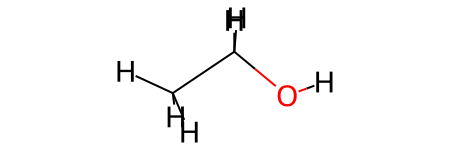

12
0 [0 1 2 3 4 5 6 7 8]
1 [0 1 2 3 4 5 7 6 8]
2 [0 1 2 3 4 6 5 7 8]
3 [0 1 2 3 4 6 7 5 8]
4 [0 1 2 3 4 7 5 6 8]
5 [0 1 2 3 4 7 6 5 8]
6 [0 1 2 4 3 5 6 7 8]
7 [0 1 2 4 3 5 7 6 8]
8 [0 1 2 4 3 6 5 7 8]
9 [0 1 2 4 3 6 7 5 8]
10 [0 1 2 4 3 7 5 6 8]
11 [0 1 2 4 3 7 6 5 8]


In [22]:
mol = mol_from_arrays(Z=train["z"], xyz=train["R"][0])
Chem.MolToMolFile(mol, "ethanol.sdf")
display(mol)
matches = mol.GetSubstructMatches(mol, uniquify=False)
print(len(matches))
#for match in matches: print(match)
matches = [
(0, 1, 2, 3, 4, 5, 6, 7, 8),
(0, 1, 2, 3, 4, 5, 7, 6, 8),
(0, 1, 2, 3, 4, 6, 5, 7, 8),
(0, 1, 2, 3, 4, 6, 7, 5, 8),
(0, 1, 2, 3, 4, 7, 5, 6, 8),
(0, 1, 2, 3, 4, 7, 6, 5, 8),
(0, 1, 2, 4, 3, 5, 6, 7, 8),
(0, 1, 2, 4, 3, 5, 7, 6, 8),
(0, 1, 2, 4, 3, 6, 5, 7, 8),
(0, 1, 2, 4, 3, 6, 7, 5, 8),
(0, 1, 2, 4, 3, 7, 5, 6, 8),
(0, 1, 2, 4, 3, 7, 6, 5, 8),
]
matches = np.asarray(matches)
# matches = matches[:1]
for i, match in enumerate(matches):
    print(i, match)

In [23]:
matches2 = np.asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8],
 [0, 1, 2, 3, 4, 6, 7, 5, 8],
 [0, 1, 2, 4, 3, 5, 7, 6, 8],
 [0, 1, 2, 4, 3, 6, 5, 7, 8],
 [0, 1, 2, 4, 3, 7, 6, 5, 8],
 [0, 1, 2, 3, 4, 7, 5, 6, 8],
])
matches2

array([[0, 1, 2, 3, 4, 5, 6, 7, 8],
       [0, 1, 2, 3, 4, 6, 7, 5, 8],
       [0, 1, 2, 4, 3, 5, 7, 6, 8],
       [0, 1, 2, 4, 3, 6, 5, 7, 8],
       [0, 1, 2, 4, 3, 7, 6, 5, 8],
       [0, 1, 2, 3, 4, 7, 5, 6, 8]])

In [24]:
X_perms = []
dX_perms = []
for match in tqdm(matches):
    X = np.asarray([inverse_distance_upper(r[match]) for r in train["R"][:n_train]])
    dX = np.asarray([inverse_distance_upper_and_jacobian(r[match])[1] for r in train["R"][:n_train]])
    X_perms.append(X)
    dX_perms.append(dX)

  0%|          | 0/12 [00:00<?, ?it/s]

In [25]:
Xt = np.asarray([inverse_distance_upper(r) for r in test["R"][:n_test]])
dXt = np.asarray([inverse_distance_upper_and_jacobian(r)[1] for r in test["R"][:n_test]])
print(Xt.shape)
print(dXt.shape)

(1000, 36)
(1000, 36, 27)


In [26]:
K = None 
for X_perm in tqdm(X_perms):
    if K is None:
        K = kernel_asymm(X, X_perm, alpha_kernel)
    else:
        K += kernel_asymm(X, X_perm, alpha_kernel)
K /= len(X_perms)

  0%|          | 0/12 [00:00<?, ?it/s]

In [27]:
print(K[:5, :6])

[[0.96895423 0.95440051 0.96537193 0.95291627 0.95941448 0.94127076]
 [0.95440051 0.97345964 0.95915216 0.9572434  0.96145874 0.9499875 ]
 [0.96537193 0.95915216 0.97565126 0.95093517 0.9539492  0.93879623]
 [0.95291627 0.9572434  0.95093517 0.96582037 0.96455501 0.95098923]
 [0.95941448 0.96145874 0.9539492  0.96455501 0.97689391 0.95891068]]


In [28]:
for i in range(K.shape[0]):
    K[i,i] += 1e-9
reg = np.linalg.solve(K, y)
reg[:10]

array([ -7138462.99421792,  14933566.94353981,  -2926763.56679886,
        -6780010.19091781,  -8331373.88438931,  -2413937.05019819,
         2524952.93342258, -36322956.08887412,   2620433.33346538,
         1955242.18694877])

In [29]:
Kt = None 
for X_perm in tqdm(X_perms):
    if Kt is None:
        Kt = kernel_asymm(Xt, X_perm, alpha_kernel)
    else:
        Kt += kernel_asymm(Xt, X_perm, alpha_kernel)
Kt /= len(X_perms)

  0%|          | 0/12 [00:00<?, ?it/s]

In [30]:
Ytt = (Kt @ reg).flatten()

RMSE = 0.45 kcal/mol
PearsonRResult(statistic=np.float64(0.9954628374268055), pvalue=np.float64(0.0))


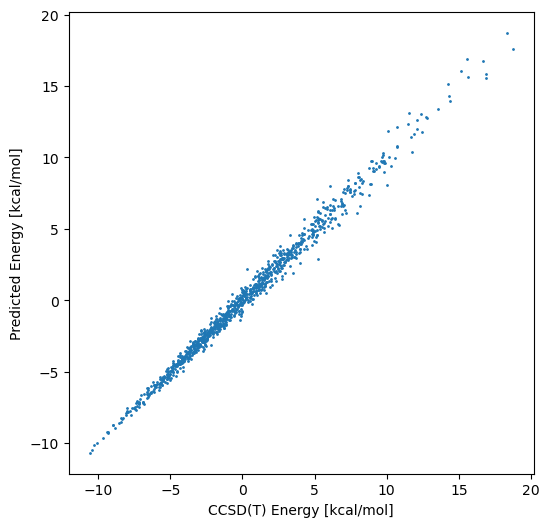

In [31]:
rmse = np.sqrt(np.mean(np.square(Yt - Ytt)))
res = pearsonr(Yt, Ytt)
print(f"RMSE = {rmse:.2} kcal/mol")
print(res)
fig = plt.figure(figsize=(6,6))
plt.xlabel("CCSD(T) Energy [kcal/mol]")
plt.ylabel("Predicted Energy [kcal/mol]")
plt.scatter(Yt, Ytt, s=1)

In [32]:
Kjac = None 
for X_perm in tqdm(X_perms):
    if Kjac is None:
        Kjac = _kernels.gaussian_jacobian_batch(Xt, dXt, X_perm, sigma)
    else:
        Kjac += _kernels.gaussian_jacobian_batch(Xt, dXt, X_perm, sigma)
        
# Kjac /= len(X_perms)

Fp = Kjac @ reg 

  0%|          | 0/12 [00:00<?, ?it/s]

RMSE = 301.65 kcal/mol/Å
PearsonRResult(statistic=np.float64(0.9945302784201498), pvalue=np.float64(0.0))


Text(0, 0.5, 'Predicted Force [kcal/mol/Å]')

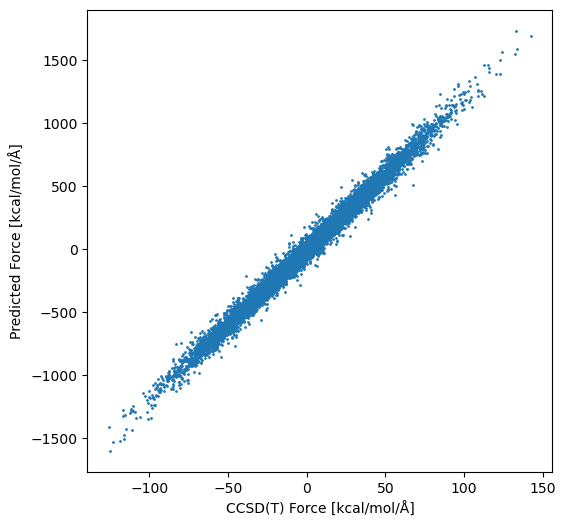

In [33]:
fig = plt.figure(figsize=(6,6))
plt.scatter(
    test["F"][:n_test].flatten(),
    -Fp.flatten(),
    s=1
)
res = pearsonr(test["F"][:n_test].flatten(), -Fp.flatten())
rmse = np.sqrt(np.mean(np.square(test["F"][:n_test].flatten() + Fp.flatten())))
print(f"RMSE = {rmse:.2f} kcal/mol/Å")
print(res)
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")

In [34]:
import numpy as np

def inverse_perm(p):
    p = np.asarray(p)
    inv = np.empty_like(p)
    inv[p] = np.arange(p.size)
    return inv

def expand_cartesian_perm(atom_perm, nm):
    """
    Repeat a 3N cartesian permutation block-diagonally for nm molecules.
    atom_perm: (N,) over atoms (0..N-1). Returns (nm*3N,) integer permutation.
    """
    atom_perm = np.asarray(atom_perm)
    N = atom_perm.size
    block = 3 * N
    cart = np.repeat(atom_perm * 3, 3) + np.tile(np.arange(3), N)   # (3N,)
    full = (cart[None, :] + block * np.arange(nm)[:, None]).ravel()
    return full

def permute_cols_inplace(H, col_perm):
    """
    In-place: H[:] = H[:, col_perm].
    Uses cycle decomposition; only one temporary column copied at a time.
    """
    m = H.shape[1]
    seen = np.zeros(m, dtype=bool)
    for s in range(m):
        if seen[s]:
            continue
        cyc = []
        j = s
        while not seen[j]:
            seen[j] = True
            cyc.append(j)
            j = col_perm[j]
        if len(cyc) > 1:
            tmp = H[:, cyc[0]].copy()
            for t in range(len(cyc) - 1):
                H[:, cyc[t]] = H[:, cyc[t+1]]
            H[:, cyc[-1]] = tmp

def permute_rows_inplace(H, row_perm):
    """
    In-place: H[:] = H[row_perm, :].
    Uses cycle decomposition; only one temporary row copied at a time.
    """
    n = H.shape[0]
    seen = np.zeros(n, dtype=bool)
    for s in range(n):
        if seen[s]:
            continue
        cyc = []
        j = s
        while not seen[j]:
            seen[j] = True
            cyc.append(j)
            j = row_perm[j]
        if len(cyc) > 1:
            tmp = H[cyc[0], :].copy()
            for t in range(len(cyc) - 1):
                H[cyc[t], :] = H[cyc[t+1], :]
            H[cyc[-1], :] = tmp


In [35]:
sigma=1.0
#nm = len(X)
nm = len(X_perms[0])
num_perms = len(matches)
H = None

n_perms = 0
for (Xp1, dXp1, p1) in tqdm(zip(X_perms, dX_perms, matches), total=len(matches)):
    row_full = expand_cartesian_perm(inverse_perm(p1), nm)  # Pg^{-1} for rows
    
    for (Xp2, dXp2, p2) in tqdm(zip(X_perms, dX_perms, matches), total=len(matches)):
        col_full = expand_cartesian_perm(inverse_perm(p2), nm)  # Ph^{-1} for cols

        H_term = rbf_hessian_full_tiled_gemm(Xp1, dXp1, Xp2, dXp2, sigma)   # rows=first, cols=second
        # Map indices back to canonical order: inverse perms on matching axes
        permute_rows_inplace(H_term, row_full)   # apply Pg^{-1} to rows
        permute_cols_inplace(H_term, col_full)   # apply Ph^{-1} to cols
        
        H = H_term if H is None else (H + H_term)
        n_perms += 1
        
# H /= float(n_perms)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
np.set_printoptions(threshold=8, linewidth=999)
-H[:5,:5]

In [ ]:
np.set_printoptions(threshold=np.inf, linewidth=999)
print(H[:27,:27][0])
np.set_printoptions(threshold=8, linewidth=999)
np.set_printoptions(threshold=np.inf, linewidth=999)

-H[:27,:12]

In [ ]:
#K_ref = np.load("K_gdml.npy")
#np.amax(K_ref + H)

In [ ]:
n = 4
W = H[:n, :n].copy() 
W
np.max(H - H.T)

In [ ]:
import scipy

In [ ]:
K_solve = H.copy()
yf = -train["F"][:n_train].flatten()
y_std = np.std(yf)
yf /= y_std

K_solve[np.diag_indices_from(K_solve)] += 1e-10
# Cholesky (do not overwrite K in case we need to retry)
L, lower = scipy.linalg.cho_factor(
    K_solve, overwrite_a=False, check_finite=False
)
alphas = -scipy.linalg.cho_solve(
    (L, lower), yf, overwrite_b=False, check_finite=False
)
print("DID CHOLESKY")
# alpha = np.linalg.solve(K_solve, yf)
reg = solve_cholesky(K_solve, yf)
print(alphas[:54])
# print(reg[:54])

In [ ]:
print(-reg[:54] / alphas[:54])
len(reg)

In [ ]:
print(sys.getrefcount(H))   # includes the temporary ref from getrefcount
for obj in gc.get_referrers(H):
    print(type(obj))
#if sys.getrefcount(H) == 2:
#    del H

In [ ]:
print(np.asarray(X_perms).shape)
print(np.asarray(dX_perms).shape)
print(matches.shape)
print(matches)
print(sigma)

In [ ]:
yf.std()

In [ ]:
Ht = None
nm = len(X_perms[0])
for (Xp, dXp, p) in tqdm(zip(X_perms, dX_perms, matches), total=len(matches)):
    H_term = rbf_hessian_full_tiled_gemm(Xt[:n_test], dXt[:n_test], Xp, dXp, 1.0)   # rows=first, cols=second
    full_col_perm = expand_cartesian_perm(inverse_perm(p), n_train)    # MUST be inverse
    permute_cols_inplace(H_term, full_col_perm)                   # columns only

    Ht = H_term if Ht is None else (Ht + H_term)

# H /= float(len(matches))
Ht *= 12 # *= yf.std()
print(Ht.shape)
(Ht)[:27, :12]

In [ ]:
Ht_ref[:27, :12] / Ht[:27, :12]

In [ ]:
-Ht_ref[:27, :12]

In [ ]:
alphas.shape

In [ ]:
Ht.shape

In [ ]:
# Fp = Ht @ alphas * y_std
Fp = -Ht @ reg * y_std
Fp.shape

In [ ]:
print(sys.getrefcount(Ht))   # includes the temporary ref from getrefcount
for obj in gc.get_referrers(Ht):
    print(type(obj))
#if sys.getrefcount(Ht) == 2:
#    del Ht

In [ ]:
# Fp.flatten()

In [ ]:
fig = plt.figure(figsize=(6,6))
Yft = test["F"][:n_test].flatten()#[:1000],

plt.scatter(Yft,  Fp, s=1)
res = pearsonr(Yft, Fp)

rmse = np.sqrt(np.mean(np.square(Yft - Fp)))

print(f"RMSE = {rmse:.2f} kcal/mol/Å")
print(res)
plt.xlim(-120,120)
plt.ylim(-120,120)
plt.xlabel("CCSD(T) Force [kcal/mol/Å]")
plt.ylabel("Predicted Force [kcal/mol/Å]")